# Transfer learning

Das Ziel des Transferlearning ist es, ein bereits trainiertes Modell auf eine andere Aufgabe zu trainieren. Die Idee dahinter ist den Teil des Netzwerks, der für die Extraktion von Merkmalen zuständig ist, zu "recyceln". Da dies in der Regel der teuerste Teil des Trainings ist, spart man sich dadurch eine Menge an Zeit. Das bedeutet, dass dieser Teil nicht neu trainiert werden muss, sondern die bereits trainierte Featurextraktion genauso gut für eine ähnliche Aufgabe verwendet werden kann. Aus diesem Grund sollte man ein bereits trainiertes Netzwerk nutzen, welches für eine ähnliche Aufgabe trainiert wurde. Lediglich die Klassifikationsschicht wird neu trainiert. Ziel dieses Notebooks ist es, ein Verständnis zu bekommen, was beim Transferlearning passiert.

Schauen Sie sich folgendes Notebook an und versuchen Sie den groben Ablauf zu verstehen.
Sie werden die meisten Befehle die Sie benötigen darin finden.
https://www.tensorflow.org/tutorials/images/transfer_learning

Für diese Aufgabe wollen wir das in der letzten Aufgabe trainierte Convolutional Neural Network, welches auf dem Mnist Datensatz trainiert wurde, auf eine andere Aufgabe trainieren. Die Aufgabe des Netzwerks soll es sein, Hexadezimalzahlen zu erkennen.
Hierzu verwenden wir den $\textit{emnist}$ Datensatz. Dieser beinhaltet zusätzlich das Alphabet (große und kleine Buchstaben). Näheres dazu unter https://pypi.org/project/emnist/ 

Gehen Sie dazu wie folgt vor:

- Laden Sie ihr Modell aus der vorherigen Aufgabe mit tf.keras.models.load_model("Name des Modells") Falls Sie ihr Modell nicht gespeichert hatten, können Sie dies mit model.save("Name des Modells"), nachdem Sie erneut trainiert haben, tun.
- Bereiten Sie den emnist-Datensatz wie in der vorherigen Aufgabe vor und sortieren Sie alle Kleinbuchstaben sowie alle Buchstaben, die nicht der Hexadezimalschreibweise angehören, aus!     
- Laden Sie das zuvor gespeicherte Modell und entfernen Sie die letzte Schicht ( model.pop() )
- Frieren Sie das Modell ein, d.h. Sie setzen die Layer auf nicht trainierbar
- Fügen Sie eine neue Schicht hinzu, sodass die verschiedenen Klassen (0-F) klassifiziert werden können (Wir beschränken uns hier auf die groß geschriebenen Buchstaben)
- Trainieren Sie das Netzwerk mit den transformierten Labels
- Plotten Sie wieder die Trainingskurven und erstellen sie eine confusion Matrix

In [1]:
# notebook funktioniert leider nur mit tensorflow version <= 2.15
# Das Mnist model zum transfer learning sollte mit der gleichen tensorflow gebaut worden sein.
!python -m pip install matplotlib numpy tensorflow==2.15 scikit-learn extra_keras_datasets

In [2]:
!pip freeze

absl-py==2.1.0
asttokens==2.4.1
astunparse==1.6.3
cachetools==5.3.3
certifi==2024.6.2
charset-normalizer==3.3.2
comm==0.2.2
contourpy==1.2.1
cycler==0.12.1
debugpy==1.8.1
decorator==5.1.1
executing==2.0.1
extra-keras-datasets==1.2.0
flatbuffers==24.3.25
fonttools==4.53.0
gast==0.5.4
google-auth==2.30.0
google-auth-oauthlib==1.2.0
google-pasta==0.2.0
grpcio==1.64.1
h5py==3.11.0
idna==3.7
ipykernel==6.29.4
ipython==8.25.0
jedi==0.19.1
joblib==1.4.2
jupyter_client==8.6.2
jupyter_core==5.7.2
keras==2.15.0
kiwisolver==1.4.5
libclang==18.1.1
Markdown==3.6
MarkupSafe==2.1.5
matplotlib==3.9.0
matplotlib-inline==0.1.7
ml-dtypes==0.2.0
nest-asyncio==1.6.0
numpy==1.26.4
oauthlib==3.2.2
opt-einsum==3.3.0
packaging==24.1
pandas==2.2.2
parso==0.8.4
pexpect==4.9.0
pillow==10.3.0
platformdirs==4.2.2
prompt_toolkit==3.0.47
protobuf==4.25.3
psutil==6.0.0
ptyprocess==0.7.0
pure-eval==0.2.2
pyasn1==0.6.0
pyasn1_modules==0.4.0
Pygments==2.18.0
pyparsing==3.1.2
python-dateutil==2.9.0.post0
pytz==2024.1
pyzm

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from sklearn.metrics import confusion_matrix 
from extra_keras_datasets import emnist

2024-06-25 16:40:40.789644: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-25 16:40:40.829298: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-25 16:40:40.932839: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-25 16:40:40.932873: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-25 16:40:40.939428: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [4]:
# Vorbereiten von Nist

(input_train, target_train), (input_test, target_test) = emnist.load_data(type='balanced')

# Sortieren Sie alle Ziffern aus, die unerwünscht sind!
# Hinweis: np.where ist hierfür recht Hilfreich
mask = list(range(0, 16))
hex_filter_train = np.isin(target_train, mask)
hex_filter_test = np.isin(target_test, mask)
X_train, Y_train = input_train[hex_filter_train], target_train[hex_filter_train]
X_test, Y_test = input_test[hex_filter_test], target_test[hex_filter_test]

INFO:root:Loading dataset = emnist


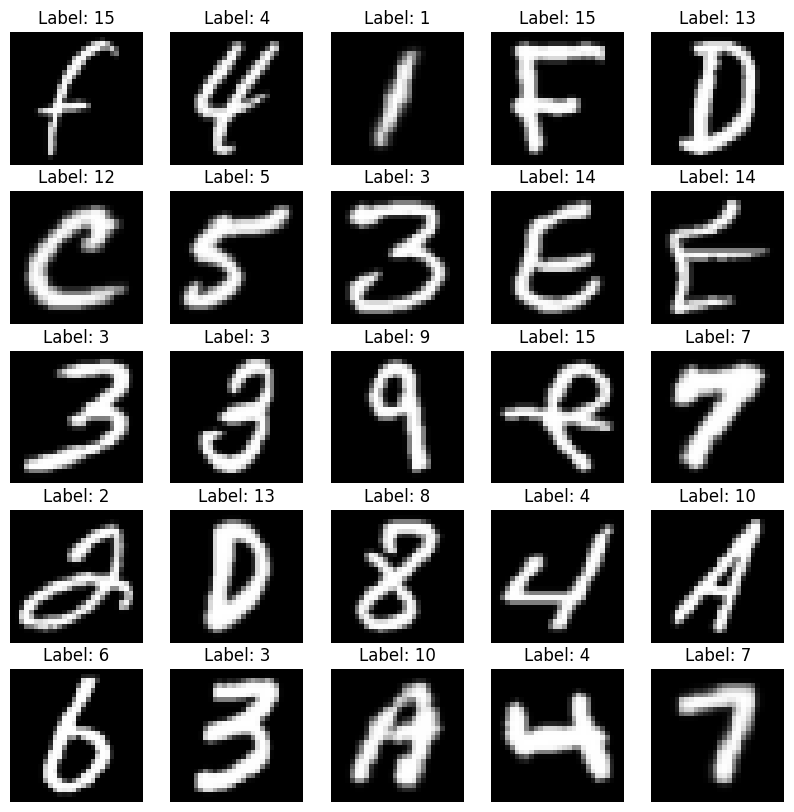

In [5]:
# Plotten Sie hier ein paar Ziffern!
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f"Label: {Y_train[i]}")
    plt.axis('off')
plt.show()

In [6]:
# Normalisieren Sie das Set und bringen es in die richtige "shape"
X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_test_norm = (X_test - np.mean(X_test)) / np.std(X_test)

X_train_norm_reshape = X_train_norm.reshape([*X_train_norm.shape, 1])
Y_train_reshape = tf.keras.utils.to_categorical(Y_train)
X_test_norm_reshape = X_test_norm.reshape([*X_test_norm.shape, 1])
Y_test_reshape = tf.keras.utils.to_categorical(Y_test)

print(np.shape(X_train_norm_reshape))
print(np.shape(Y_train_reshape))
print(np.shape(X_test_norm_reshape))
print(np.shape(Y_test_reshape))

(38400, 28, 28, 1)
(38400, 16)
(6400, 28, 28, 1)
(6400, 16)


In [7]:

# Laden des Modells
base_model = tf.keras.models.load_model("mnist_model.keras")

#Hier die letzte Schicht entfernen
base_model.pop()
base_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

In [8]:

# Modell einfrieren
base_model.trainable = False

# Basismodell als Ausgangspunkt nehmen
inputs = tf.keras.Input(shape=(28, 28,1))
x = base_model(inputs=[inputs], training=False)

# Hier einen Dense-layer und einmal Softmax hinzufügen, sodass die verschiedenen Klassen vorhergesagt werden können!
last_layer = tf.keras.layers.Dense(16)(x)
output = tf.keras.layers.Activation('softmax')(last_layer)

# Modell Zusammenfügen
model = tf.keras.Model(inputs=[inputs], outputs=output)

In [9]:
# Modell Kompilieren, Kostenfunktion categorical_crossentropy, Optimizer Adam mit der learningrate 1e-4
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 sequential (Sequential)     (None, 1600)              18816     
                                                                 
 dense (Dense)               (None, 16)                25616     
                                                                 
 activation (Activation)     (None, 16)                0         
                                                                 
Total params: 44432 (173.56 KB)
Trainable params: 25616 (100.06 KB)
Non-trainable params: 18816 (73.50 KB)
_________________________________________________________________


In [10]:
# Accuracy vor dem Transferlearning bestimmen
loss, accuracy = model.evaluate(X_test_norm_reshape, Y_test_reshape)

200/200 [==============================] - 1s 2ms/step - loss: 4.4966 - accuracy: 0.0605


In [11]:
# Hier das Netzwerk für 10 Epochen trainieren!
history = model.fit(X_train_norm_reshape, Y_train_reshape,
                  batch_size=128,
                  epochs=10,
                  validation_data=(X_test_norm_reshape, Y_test_reshape)
                 )

Epoch 1/10
300/300 [==============================] - 2s 7ms/step - loss: 1.1498 - accuracy: 0.6758 - val_loss: 0.3740 - val_accuracy: 0.8961
Epoch 2/10
300/300 [==============================] - 2s 7ms/step - loss: 0.2833 - accuracy: 0.9207 - val_loss: 0.2170 - val_accuracy: 0.9389
Epoch 3/10
300/300 [==============================] - 2s 7ms/step - loss: 0.1884 - accuracy: 0.9479 - val_loss: 0.1644 - val_accuracy: 0.9550
Epoch 4/10
300/300 [==============================] - 2s 7ms/step - loss: 0.1476 - accuracy: 0.9593 - val_loss: 0.1399 - val_accuracy: 0.9600
Epoch 5/10
300/300 [==============================] - 2s 7ms/step - loss: 0.1237 - accuracy: 0.9654 - val_loss: 0.1225 - val_accuracy: 0.9650
Epoch 6/10
300/300 [==============================] - 2s 7ms/step - loss: 0.1074 - accuracy: 0.9702 - val_loss: 0.1112 - val_accuracy: 0.9673
Epoch 7/10
300/300 [==============================] - 2s 7ms/step - loss: 0.0957 - accuracy: 0.9733 - val_loss: 0.1030 - val_accuracy: 0.9684
Epoch 

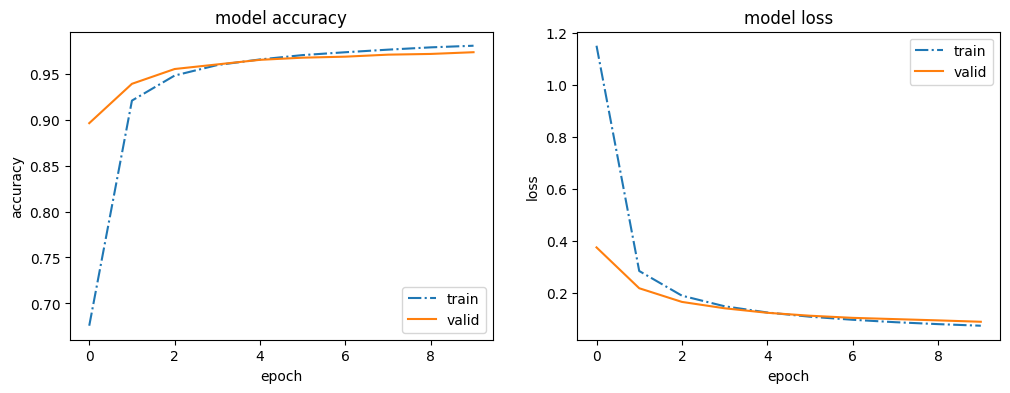

In [12]:
# Plotten der Trainingskurve wie in der Aufgabe zuvor
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

In [13]:
# Confusion Matrix erstellen
pred=model.predict(X_test_norm_reshape)
print(confusion_matrix(np.argmax(Y_test_reshape,axis=1),np.argmax(pred,axis=1)))

200/200 [==============================] - 0s 2ms/step
[[380   0   0   0   0   0   2   0   0   0   1   1   0  16   0   0]
 [  0 396   2   0   0   0   0   2   0   0   0   0   0   0   0   0]
 [  1   0 393   1   0   1   0   0   2   0   0   2   0   0   0   0]
 [  1   0   0 394   0   2   0   0   1   1   0   1   0   0   0   0]
 [  1   1   0   0 387   0   1   0   0   3   2   0   1   1   0   3]
 [  1   0   0   0   1 390   1   0   0   2   0   0   1   0   1   3]
 [  0   2   0   0   0   1 396   0   0   0   0   0   1   0   0   0]
 [  0   1   1   0   0   0   0 393   0   1   1   0   0   1   0   2]
 [  0   0   0   0   0   2   0   0 386   3   1   5   0   1   0   2]
 [  2   0   0   0   4   0   0   1   2 391   0   0   0   0   0   0]
 [  0   0   1   0   1   0   0   2   0   0 393   1   0   1   0   1]
 [  3   0   0   3   0   0   1   1   6   0   6 376   0   0   3   1]
 [  2   0   1   0   0   0   2   0   0   0   0   0 392   0   2   1]
 [ 20   0   0   1   0   0   0   0   0   0   2   2   1 374   0   0]
 [  0  